# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.layers import concatenate, Activation

from tensorflow.keras import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score


from imblearn.metrics import specificity_score


from  matplotlib import pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Input data

In [2]:
targetnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']
batch_size = 16
image_size = 224

In [3]:
train_path = '/kaggle/input/garbase/garbage_classification/train'
test_path = '/kaggle/input/garbase/garbage_classification/test'
val_path = '/kaggle/input/garbase/garbage_classification/val'

# Layer 1 (DN)

## DN121

### Data Generation

In [4]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [5]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


### Import model

In [6]:
from tensorflow.keras.applications.densenet import DenseNet121
# Create a new instance of DenseNet121
DN121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

29084464/29084464 [==============================] - 1s 0us/step


In [7]:
## Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
dn121 = DN121(MainInput)

# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 4))(dn121)

### DN121_cacnn

In [8]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [9]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn121_ca = Model(inputs=MainInput, outputs=conv)

12


In [10]:
from tensorflow.keras import models
model_dn121_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn121/DN121_CA.hdf5")

In [11]:
predictions_dn121_ca = model_dn121_ca.predict(test_batches)

195/195 [==============================] - 27s 94ms/step


In [12]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn121_ca, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn121_ca

In [13]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.96      0.97       190
  biological       0.98      0.98      0.98       198
 brown-glass       0.96      0.97      0.96       123
   cardboard       0.93      0.96      0.94       179
     clothes       1.00      0.99      0.99      1066
 green-glass       0.93      0.98      0.95       127
       metal       0.91      0.89      0.90       155
       paper       0.94      0.96      0.95       210
     plastic       0.90      0.90      0.90       174
       shoes       0.97      0.97      0.97       397
       trash       0.98      0.95      0.96       141
 white-glass       0.94      0.90      0.92       156

    accuracy                           0.97      3116
   macro avg       0.95      0.95      0.95      3116
weighted avg       0.97      0.97      0.97      3116



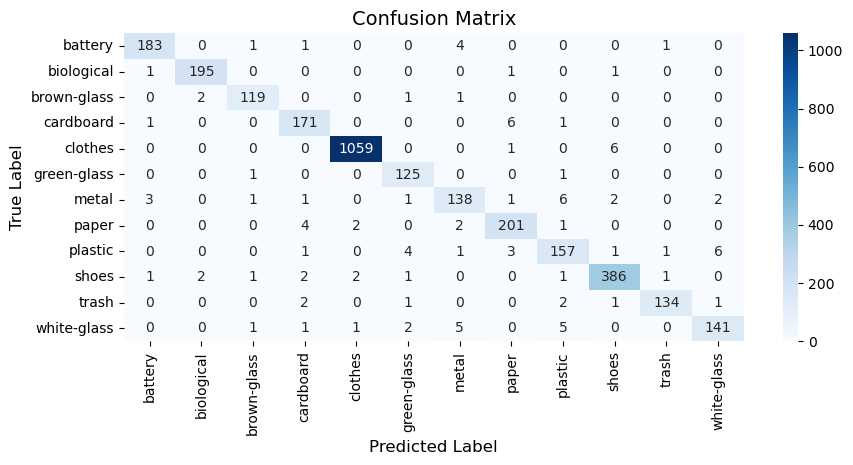

In [14]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [15]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9656611039794608


In [16]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn121_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn121_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9656611039794608
Top-2 Accuracy: 0.9871630295250321
Top-3 Accuracy: 0.9926187419768935


In [17]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9657417259988558
Weighted Recall (sensitivity): 0.9656611039794608
Weighted F1-Score: 0.9656190972337215
Weighted Specificity: 0.996983794611796
weighted Roc score: 0.9984543164601978


### DN121_seacnn

In [18]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [19]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn121_sea = Model(inputs=MainInput, outputs=conv)

12


In [20]:
from tensorflow.keras import models
model_dn121_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn121/DN121_SEA.hdf5")

In [21]:
predictions_dn121_sea = model_dn121_sea.predict(test_batches)

195/195 [==============================] - 11s 46ms/step


In [22]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn121_sea, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn121_sea

In [23]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']


from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.96      0.96       190
  biological       0.97      0.98      0.97       198
 brown-glass       0.93      0.96      0.94       123
   cardboard       0.98      0.93      0.96       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.96      0.96      0.96       127
       metal       0.84      0.92      0.88       155
       paper       0.97      0.95      0.96       210
     plastic       0.91      0.90      0.91       174
       shoes       0.97      0.97      0.97       397
       trash       0.95      0.99      0.97       141
 white-glass       0.93      0.81      0.87       156

    accuracy                           0.96      3116
   macro avg       0.95      0.94      0.95      3116
weighted avg       0.96      0.96      0.96      3116



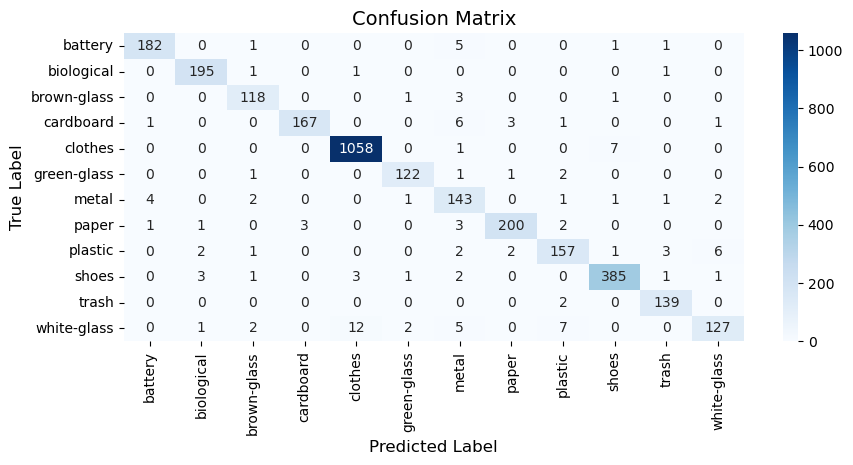

In [24]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [25]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9605263157894737


In [26]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn121_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn121_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9605263157894737
Top-2 Accuracy: 0.9858793324775353
Top-3 Accuracy: 0.9929396662387676


In [27]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9609989256298085
Weighted Recall (sensitivity): 0.9605263157894737
Weighted F1-Score: 0.9603940916885217
Weighted Specificity: 0.995121599237572
weighted Roc score: 0.9936634755417618


### DN121_sacnn

In [28]:
### Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [29]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn121_sa = Model(inputs=MainInput, outputs=conv)

12


In [30]:
from tensorflow.keras import models
model_dn121_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn121/DN121_SA.hdf5")

In [31]:
predictions_dn121_sa = model_dn121_sa.predict(test_batches)

195/195 [==============================] - 12s 52ms/step


In [32]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn121_sa, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn121_sa

In [33]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.95      0.96       190
  biological       0.93      0.99      0.96       198
 brown-glass       0.97      0.93      0.95       123
   cardboard       0.98      0.95      0.97       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.94      0.99      0.97       127
       metal       0.84      0.95      0.89       155
       paper       0.97      0.94      0.95       210
     plastic       0.94      0.93      0.93       174
       shoes       0.98      0.96      0.97       397
       trash       0.97      0.98      0.97       141
 white-glass       0.96      0.89      0.92       156

    accuracy                           0.97      3116
   macro avg       0.95      0.95      0.95      3116
weighted avg       0.97      0.97      0.97      3116



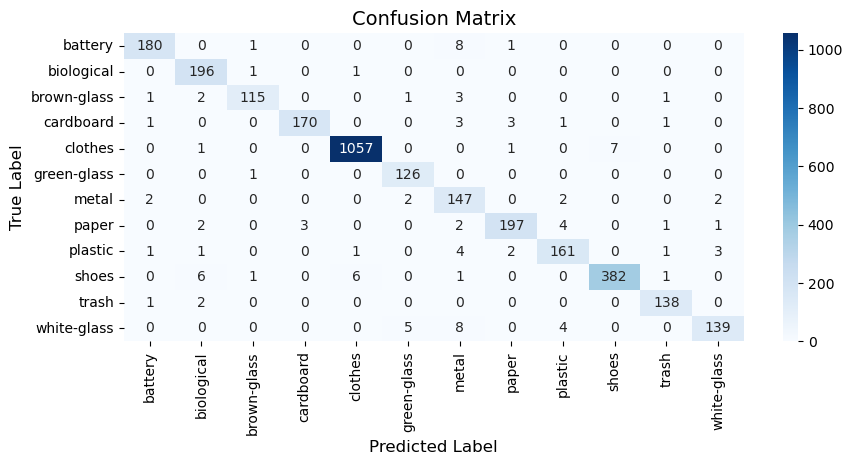

In [34]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [35]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9653401797175867


In [36]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn121_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn121_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9653401797175867
Top-2 Accuracy: 0.9878048780487805
Top-3 Accuracy: 0.9929396662387676


In [37]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.966444192284533
Weighted Recall (sensitivity): 0.9653401797175867
Weighted F1-Score: 0.965507320484914
Weighted Specificity: 0.9966506847579057
weighted Roc score: 0.9986066917732355


### MV

In [38]:
# Take the majority vote of the predictions for each image
MV_predictions_dn121 = predictions_dn121_ca + predictions_dn121_sa + predictions_dn121_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_dn121_f = np.argmax(MV_predictions_dn121, axis=1)

In [39]:
y_pred = MV_predictions_dn121_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9733632862644416


In [40]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.973617593442497
Weighted Recall (sensitivity): 0.9733632862644416
Weighted F1-Score: 0.9733403808153542
Weighted Specificity: 0.9971682939079525
weighted Roc score: 0.9986066917732355


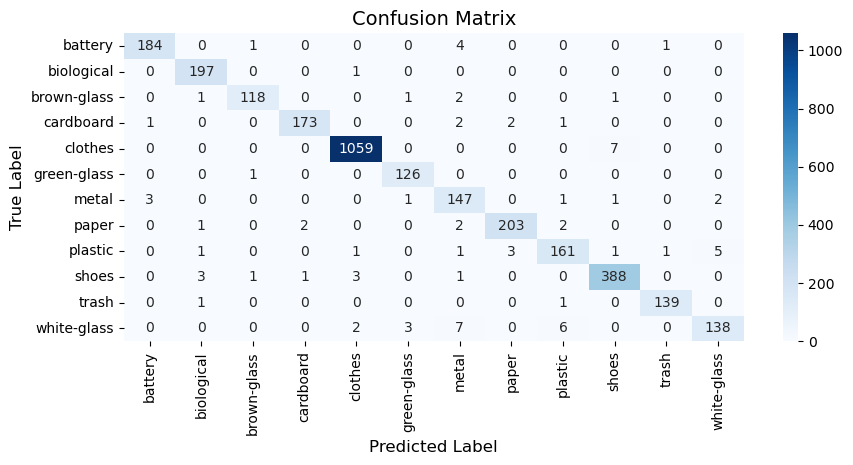

In [41]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [42]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.34%
Accuracy for each class:
Class 0: 96.84%
Class 1: 99.49%
Class 2: 95.93%
Class 3: 96.65%
Class 4: 99.34%
Class 5: 99.21%
Class 6: 94.84%
Class 7: 96.67%
Class 8: 92.53%
Class 9: 97.73%
Class 10: 98.58%
Class 11: 88.46%


## DN169

### Data Generation

In [43]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [44]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


### Import model

In [45]:
from tensorflow.keras.applications.densenet import DenseNet169

DN169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

51877672/51877672 [==============================] - 3s 0us/step


In [46]:
# Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
dn169 = DN169(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((8, 8, 26))(dn169)

### DN169_cacnn

In [47]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [48]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn169_ca = Model(inputs=MainInput, outputs=conv)

12


In [49]:
from tensorflow.keras import models
model_dn169_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn169/DN169_CA.hdf5")

In [50]:
predictions_dn169_ca = model_dn169_ca.predict(test_batches)

195/195 [==============================] - 18s 72ms/step


In [51]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_ca, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn169_ca

In [52]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.97      0.97       190
  biological       0.98      0.98      0.98       198
 brown-glass       0.96      0.98      0.97       123
   cardboard       0.98      0.96      0.97       179
     clothes       1.00      0.99      0.99      1066
 green-glass       0.93      0.98      0.95       127
       metal       0.94      0.93      0.93       155
       paper       0.97      0.97      0.97       210
     plastic       0.96      0.93      0.94       174
       shoes       0.97      0.98      0.98       397
       trash       0.98      0.97      0.98       141
 white-glass       0.96      0.94      0.95       156

    accuracy                           0.97      3116
   macro avg       0.96      0.96      0.96      3116
weighted avg       0.97      0.97      0.97      3116



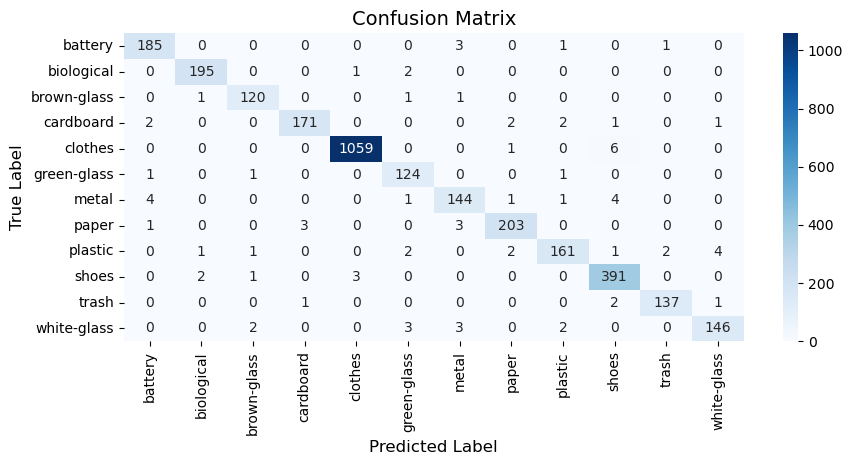

In [53]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [54]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9743260590500642


In [55]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9743260590500642
Top-2 Accuracy: 0.9906931964056482
Top-3 Accuracy: 0.995186136071887


In [56]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9744163437733362
Weighted Recall (sensitivity): 0.9743260590500642
Weighted F1-Score: 0.9742982572312043
Weighted Specificity: 0.9975686252902102
weighted Roc score: 0.9988146404217044


### DN169_seacnn

In [57]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [58]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 4
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn169_sea = Model(inputs=MainInput, outputs=conv)

12


In [59]:
from tensorflow.keras import models
model_dn169_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn169/DN169_SEA.hdf5")

In [60]:
predictions_dn169_sea = model_dn169_sea.predict(test_batches)

195/195 [==============================] - 18s 77ms/step


In [61]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_sea, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn169_sea

In [62]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.98      0.96      0.97       190
  biological       0.98      0.99      0.99       198
 brown-glass       0.93      0.99      0.96       123
   cardboard       0.99      0.97      0.98       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.98      0.95      0.96       127
       metal       0.93      0.94      0.93       155
       paper       0.97      0.98      0.97       210
     plastic       0.92      0.92      0.92       174
       shoes       0.98      0.97      0.98       397
       trash       0.97      0.99      0.98       141
 white-glass       0.93      0.91      0.92       156

    accuracy                           0.97      3116
   macro avg       0.96      0.96      0.96      3116
weighted avg       0.97      0.97      0.97      3116



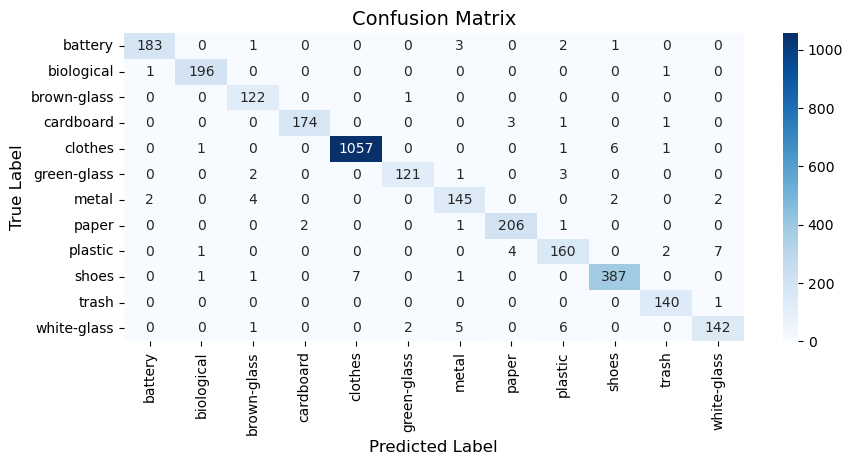

In [63]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [64]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9733632862644416


In [65]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9733632862644416
Top-2 Accuracy: 0.9929396662387676
Top-3 Accuracy: 0.9961489088575096


In [66]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9734921368280812
Weighted Recall (sensitivity): 0.9733632862644416
Weighted F1-Score: 0.9733525722737861
Weighted Specificity: 0.9972254949475456
weighted Roc score: 0.9988617301185098


### DN169_sacnn

In [67]:
### Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [68]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn169_sa = Model(inputs=MainInput, outputs=conv)

12


In [69]:
from tensorflow.keras import models
model_dn169_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn169/DN169_SA.hdf5")

In [70]:
predictions_dn169_sa = model_dn169_sa.predict(test_batches)

195/195 [==============================] - 13s 50ms/step


In [71]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_sa, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn169_sa

In [72]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.98      0.97       190
  biological       0.96      0.99      0.98       198
 brown-glass       0.97      0.97      0.97       123
   cardboard       0.99      0.94      0.97       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.95      0.98      0.97       127
       metal       0.90      0.94      0.91       155
       paper       0.96      0.98      0.97       210
     plastic       0.91      0.91      0.91       174
       shoes       0.97      0.96      0.96       397
       trash       0.99      0.98      0.99       141
 white-glass       0.93      0.90      0.91       156

    accuracy                           0.97      3116
   macro avg       0.96      0.96      0.96      3116
weighted avg       0.97      0.97      0.97      3116



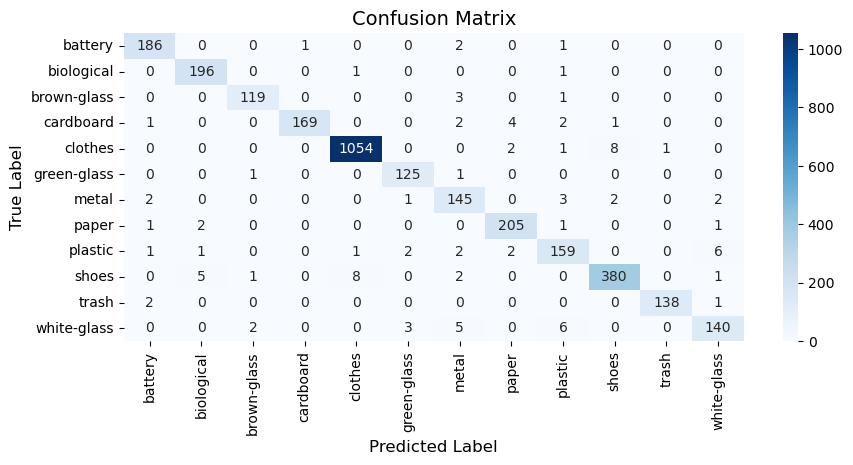

In [73]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [74]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9679075738125802


In [75]:
import numpy as np
from sklearn.metrics import accuracy_score


# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9679075738125802
Top-2 Accuracy: 0.9884467265725289
Top-3 Accuracy: 0.9913350449293966


In [76]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9681793382608963
Weighted Recall (sensitivity): 0.9679075738125802
Weighted F1-Score: 0.9679317797201421
Weighted Specificity: 0.9963654720480172
weighted Roc score: 0.9980198250556168


### SAvg

In [77]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_dn169 = (predictions_dn169_ca + predictions_dn169_sa + predictions_dn169_sea) / 3

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_dn169, axis=1)

In [78]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9794608472400513


In [79]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9795007257633113
Weighted Recall (sensitivity): 0.9794608472400513
Weighted F1-Score: 0.9794198298385444
Weighted Specificity: 0.9976464100868994
weighted Roc score: 0.9980198250556168


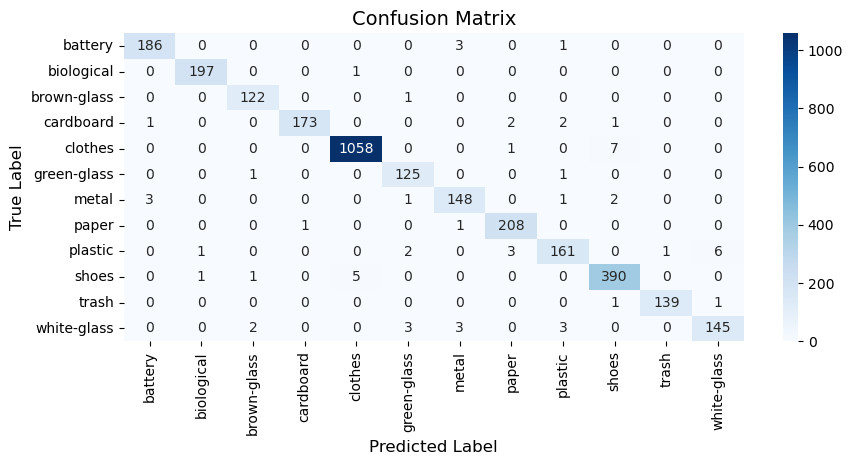

In [80]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [81]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.95%
Accuracy for each class:
Class 0: 97.89%
Class 1: 99.49%
Class 2: 99.19%
Class 3: 96.65%
Class 4: 99.25%
Class 5: 98.43%
Class 6: 95.48%
Class 7: 99.05%
Class 8: 92.53%
Class 9: 98.24%
Class 10: 98.58%
Class 11: 92.95%


## DN201

### Data Generation

In [82]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [83]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


### Import model

In [84]:
from tensorflow.keras.applications.densenet import DenseNet201
# Create a new instance of DenseNet201
DN201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

74836368/74836368 [==============================] - 3s 0us/step


In [85]:
## Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
densenet = DN201(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((8, 8, 30))(densenet)

### DN201_cacnn

In [86]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [87]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn201_ca = Model(inputs=MainInput, outputs=conv)

12


In [88]:
from tensorflow.keras import models
model_dn201_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn201/DN201_CA.hdf5")

In [89]:
predictions_dn201_ca = model_dn201_ca.predict(test_batches)

195/195 [==============================] - 23s 95ms/step


In [90]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_ca, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn201_ca

In [91]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.97      0.97       190
  biological       0.97      0.98      0.98       198
 brown-glass       0.98      0.98      0.98       123
   cardboard       0.98      0.98      0.98       179
     clothes       1.00      0.99      0.99      1066
 green-glass       0.96      0.98      0.97       127
       metal       0.93      0.94      0.93       155
       paper       0.98      0.96      0.97       210
     plastic       0.89      0.94      0.92       174
       shoes       0.98      0.97      0.98       397
       trash       0.96      0.96      0.96       141
 white-glass       0.94      0.95      0.95       156

    accuracy                           0.97      3116
   macro avg       0.96      0.97      0.96      3116
weighted avg       0.97      0.97      0.97      3116



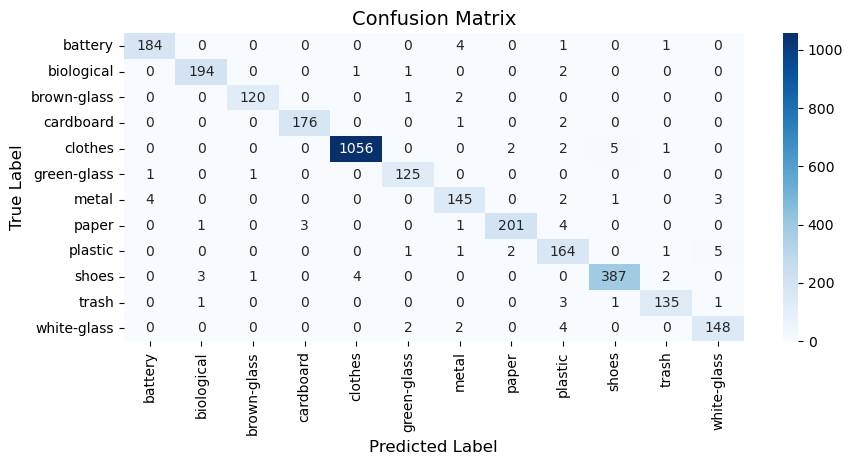

In [92]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [93]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.97400513478819


In [94]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.97400513478819
Top-2 Accuracy: 0.9932605905006419
Top-3 Accuracy: 0.996790757381258


In [95]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9743588955478285
Weighted Recall (sensitivity): 0.97400513478819
Weighted F1-Score: 0.9741205499882933
Weighted Specificity: 0.9975858354308832
weighted Roc score: 0.9988593568971124


### DN201_seacnn

In [96]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [97]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 4
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn201_sea = Model(inputs=MainInput, outputs=conv)

12


In [98]:
from tensorflow.keras import models
model_dn201_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn201/DN201_SEA.hdf5")

In [99]:
predictions_dn201_sea = model_dn201_sea.predict(test_batches)

195/195 [==============================] - 17s 72ms/step


In [100]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_sea, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn201_sea

In [101]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.94      0.97      0.96       190
  biological       0.98      0.99      0.98       198
 brown-glass       0.98      0.96      0.97       123
   cardboard       0.98      0.96      0.97       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.98      0.98      0.98       127
       metal       0.93      0.91      0.92       155
       paper       0.96      0.96      0.96       210
     plastic       0.93      0.90      0.91       174
       shoes       0.97      0.97      0.97       397
       trash       0.96      0.98      0.97       141
 white-glass       0.91      0.94      0.92       156

    accuracy                           0.97      3116
   macro avg       0.96      0.96      0.96      3116
weighted avg       0.97      0.97      0.97      3116



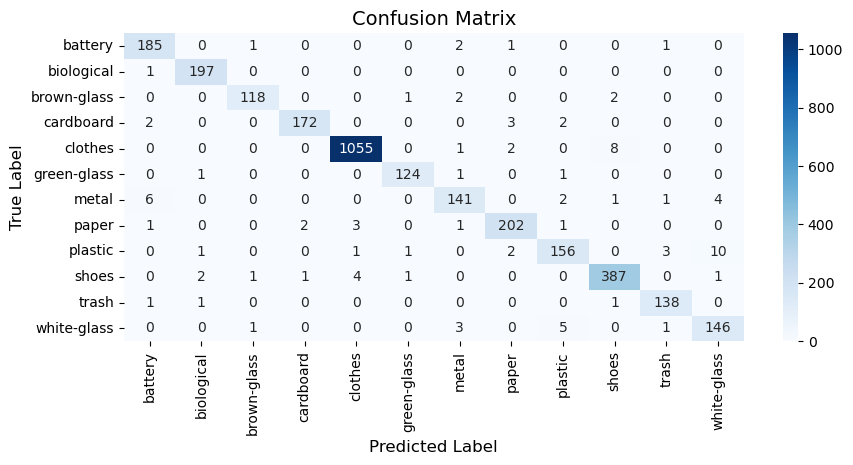

In [102]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [103]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9695121951219512


In [104]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9695121951219512
Top-2 Accuracy: 0.9926187419768935
Top-3 Accuracy: 0.9958279845956355


In [105]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9695828046077004
Weighted Recall (sensitivity): 0.9695121951219512
Weighted F1-Score: 0.9694702607496795
Weighted Specificity: 0.996718118487053
weighted Roc score: 0.9988944830586348


### DN201_sacnn

In [106]:
### Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [107]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_dn201_sa = Model(inputs=MainInput, outputs=conv)

12


In [108]:
from tensorflow.keras import models
model_dn201_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/dn/dn201/DN201_SA.hdf5")

In [109]:
predictions_dn201_sa = model_dn201_sa.predict(test_batches)

195/195 [==============================] - 16s 62ms/step


In [110]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_sa, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn201_sa

In [111]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.96      0.97      0.97       190
  biological       0.97      0.99      0.98       198
 brown-glass       0.96      0.97      0.96       123
   cardboard       0.99      0.96      0.97       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.96      0.99      0.98       127
       metal       0.91      0.89      0.90       155
       paper       0.96      0.96      0.96       210
     plastic       0.89      0.90      0.89       174
       shoes       0.97      0.97      0.97       397
       trash       0.98      0.96      0.97       141
 white-glass       0.90      0.92      0.91       156

    accuracy                           0.97      3116
   macro avg       0.95      0.96      0.96      3116
weighted avg       0.97      0.97      0.97      3116



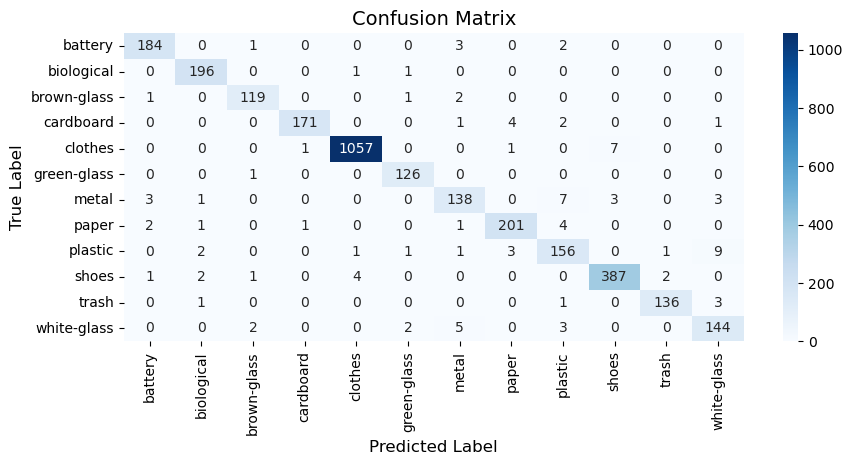

In [112]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [113]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9675866495507061


In [114]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9675866495507061
Top-2 Accuracy: 0.9906931964056482
Top-3 Accuracy: 0.9958279845956355


In [115]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9677145435052755
Weighted Recall (sensitivity): 0.9675866495507061
Weighted F1-Score: 0.9675954403913972
Weighted Specificity: 0.9969777846027885
weighted Roc score: 0.9985725225569946


### WAvg

In [116]:
# weighted average

# Define the weights for each model's prediction
weights = [0.20, .60, .20]


In [117]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_dn201 = (weights[0] * predictions_dn201_sa) + (weights[1] *  predictions_dn201_ca) + (weights[2] * predictions_dn201_sea) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_dn201, axis=1)

In [118]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9765725288831836


In [119]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9768797354323527
Weighted Recall (sensitivity): 0.9765725288831836
Weighted F1-Score: 0.9766634942836999
Weighted Specificity: 0.9977328274999642
weighted Roc score: 0.9985725225569946


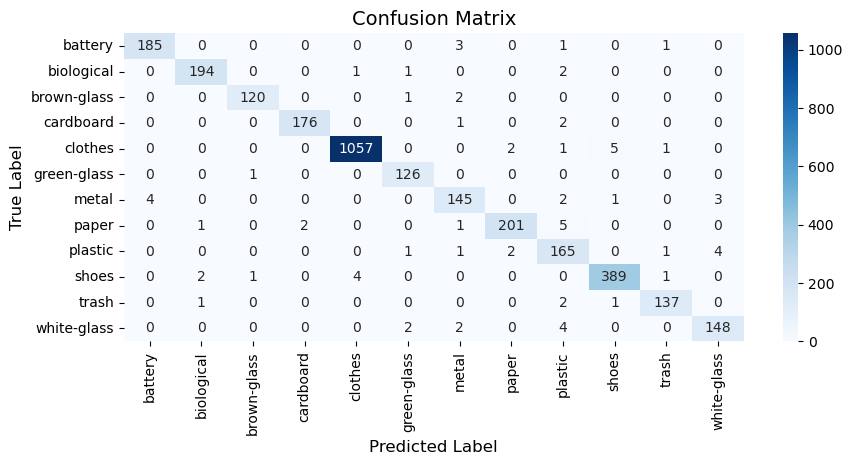

In [120]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [121]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.66%
Accuracy for each class:
Class 0: 97.37%
Class 1: 97.98%
Class 2: 97.56%
Class 3: 98.32%
Class 4: 99.16%
Class 5: 99.21%
Class 6: 93.55%
Class 7: 95.71%
Class 8: 94.83%
Class 9: 97.98%
Class 10: 97.16%
Class 11: 94.87%


### 2nd layer DN

In [122]:
# dn121 = most
# dn201 = 2nd most
# dn169 = 3rd

In [123]:
# Define the weights for each model's prediction
weights = [0.34, .33, .33]

In [124]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_dn2 = (weights[0] * MV_predictions_dn121) + (weights[1] * WAvg_predictions_dn201) + (weights[2] * SAvg_predictions_dn169) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_dn2, axis=1)

In [125]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9768934531450578


In [126]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9770956102525727
Weighted Recall (sensitivity): 0.9768934531450578
Weighted F1-Score: 0.9768920037750602
Weighted Specificity: 0.9976771994004727
weighted Roc score: 0.9985725225569946


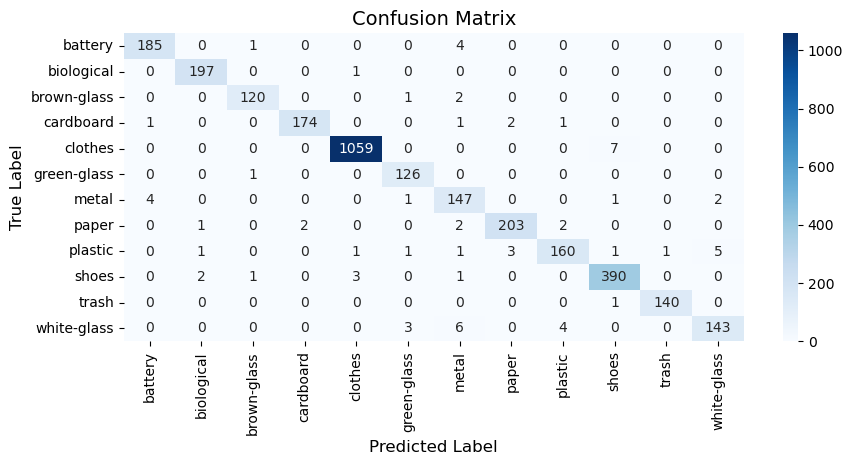

In [127]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [128]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.69%
Accuracy for each class:
Class 0: 97.37%
Class 1: 99.49%
Class 2: 97.56%
Class 3: 97.21%
Class 4: 99.34%
Class 5: 99.21%
Class 6: 94.84%
Class 7: 96.67%
Class 8: 91.95%
Class 9: 98.24%
Class 10: 99.29%
Class 11: 91.67%


# Layer 1 (RN)

## RN50

### Data Generation

In [129]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [130]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


### Import model

In [131]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Create a new instance of ResNet50
RN50 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

94765736/94765736 [==============================] - 3s 0us/step


In [132]:
# Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
resnet = RN50(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(resnet)

### RN50_cacnn

In [133]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [134]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn50_ca = Model(inputs=MainInput, outputs=conv)

12


In [135]:
from tensorflow.keras import models
model_rn50_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn50/RN50_CA.hdf5")

In [136]:
predictions_rn50_ca = model_rn50_ca.predict(test_batches)

195/195 [==============================] - 14s 60ms/step


In [137]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_ca

In [138]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.94      0.96      0.95       190
  biological       0.97      0.99      0.98       198
 brown-glass       0.95      0.97      0.96       123
   cardboard       0.97      0.95      0.96       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.96      0.98      0.97       127
       metal       0.91      0.89      0.90       155
       paper       0.94      0.95      0.95       210
     plastic       0.92      0.87      0.89       174
       shoes       0.97      0.95      0.96       397
       trash       0.97      0.95      0.96       141
 white-glass       0.88      0.93      0.90       156

    accuracy                           0.96      3116
   macro avg       0.95      0.95      0.95      3116
weighted avg       0.96      0.96      0.96      3116



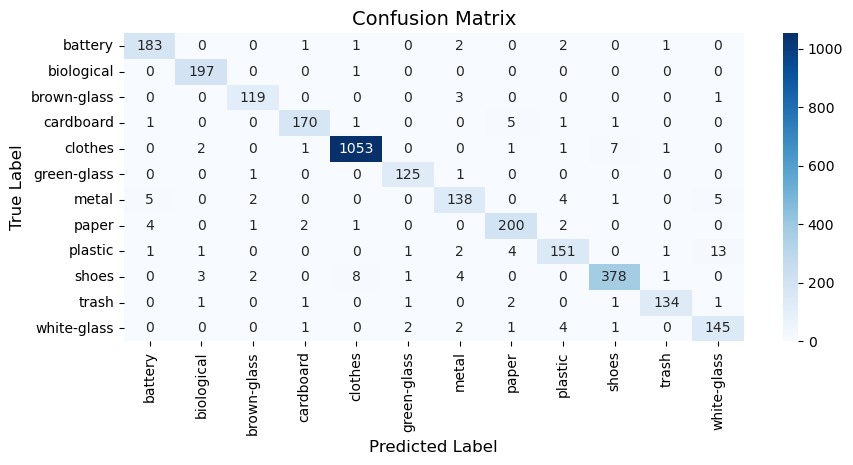

In [139]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [140]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9605263157894737


In [141]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9605263157894737
Top-2 Accuracy: 0.9855584082156611
Top-3 Accuracy: 0.9945442875481386


In [142]:

### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9606711837891684
Weighted Recall (sensitivity): 0.9605263157894737
Weighted F1-Score: 0.9604708266924447
Weighted Specificity: 0.9956341424197109
weighted Roc score: 0.9984212393529422


### RN50_seacnn

In [143]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [144]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn50_sea = Model(inputs=MainInput, outputs=conv)

12


In [145]:
from tensorflow.keras import models
model_rn50_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn50/RN50_SEA.hdf5")

In [146]:
predictions_rn50_sea = model_rn50_sea.predict(test_batches)

195/195 [==============================] - 15s 69ms/step


In [147]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_sea

In [148]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.93      0.95       190
  biological       0.96      0.97      0.97       198
 brown-glass       0.93      0.95      0.94       123
   cardboard       0.96      0.97      0.96       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.94      0.94      0.94       127
       metal       0.82      0.90      0.86       155
       paper       0.93      0.94      0.94       210
     plastic       0.92      0.87      0.89       174
       shoes       0.95      0.95      0.95       397
       trash       0.96      0.96      0.96       141
 white-glass       0.93      0.89      0.91       156

    accuracy                           0.95      3116
   macro avg       0.94      0.94      0.94      3116
weighted avg       0.95      0.95      0.95      3116



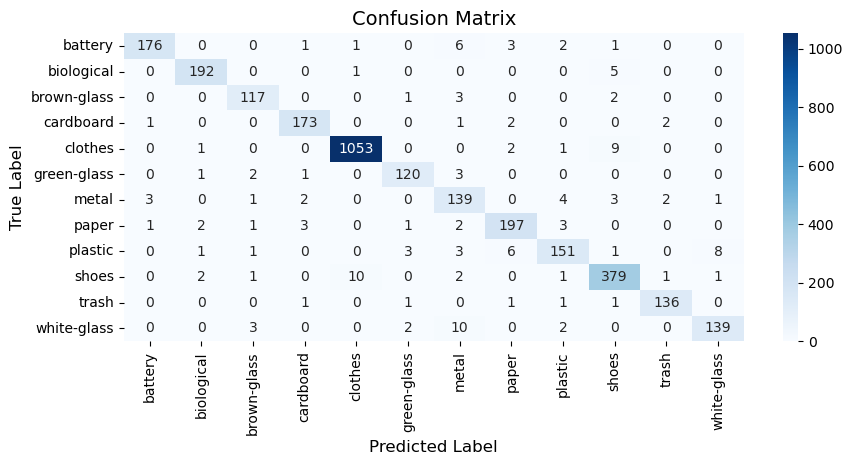

In [149]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [150]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9537869062901155


In [151]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9537869062901155
Top-2 Accuracy: 0.9833119383825417
Top-3 Accuracy: 0.9903722721437741


In [152]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9543254323348149
Weighted Recall (sensitivity): 0.9537869062901155
Weighted F1-Score: 0.9538715881485677
Weighted Specificity: 0.9949860904210606
weighted Roc score: 0.9981038556985826


**RN50_sacnn**

In [153]:
### Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [154]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn50_sa = Model(inputs=MainInput, outputs=conv)

12


In [155]:
from tensorflow.keras import models
model_rn50_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn50/RN50_SA.hdf5")


In [156]:
predictions_rn50_sa = model_rn50_sa.predict(test_batches)

195/195 [==============================] - 11s 52ms/step


In [157]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_sa

In [158]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.95      0.94      0.95       190
  biological       0.96      0.99      0.98       198
 brown-glass       0.95      0.98      0.96       123
   cardboard       0.97      0.96      0.97       179
     clothes       1.00      0.99      0.99      1066
 green-glass       0.95      0.96      0.96       127
       metal       0.86      0.89      0.88       155
       paper       0.94      0.95      0.95       210
     plastic       0.88      0.85      0.87       174
       shoes       0.98      0.97      0.97       397
       trash       0.97      0.95      0.96       141
 white-glass       0.89      0.90      0.89       156

    accuracy                           0.96      3116
   macro avg       0.94      0.95      0.94      3116
weighted avg       0.96      0.96      0.96      3116



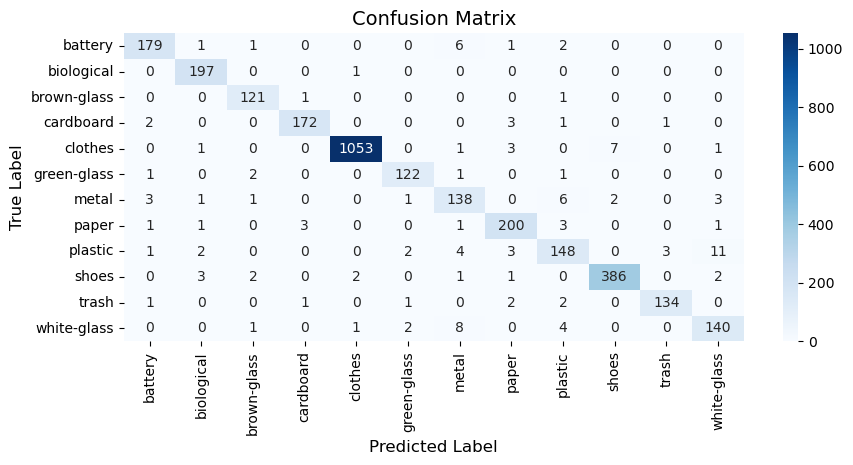

In [159]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [160]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.959563543003851


In [161]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.959563543003851
Top-2 Accuracy: 0.980423620025674
Top-3 Accuracy: 0.9900513478818999


In [162]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9597994741293571
Weighted Recall (sensitivity): 0.959563543003851
Weighted F1-Score: 0.9595953245815831
Weighted Specificity: 0.9968393120980709
weighted Roc score: 0.9977873249222763


### MV

In [163]:
# Take the majority vote of the predictions for each image
MV_predictions_rn50 = predictions_rn50_ca + predictions_rn50_sa + predictions_rn50_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_rn50_f = np.argmax(MV_predictions_rn50, axis=1)

In [164]:
y_pred = MV_predictions_rn50_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9669448010269577


In [165]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9669337376191143
Weighted Recall (sensitivity): 0.9669448010269577
Weighted F1-Score: 0.9668445453756342
Weighted Specificity: 0.9967573848752862
weighted Roc score: 0.9977873249222763


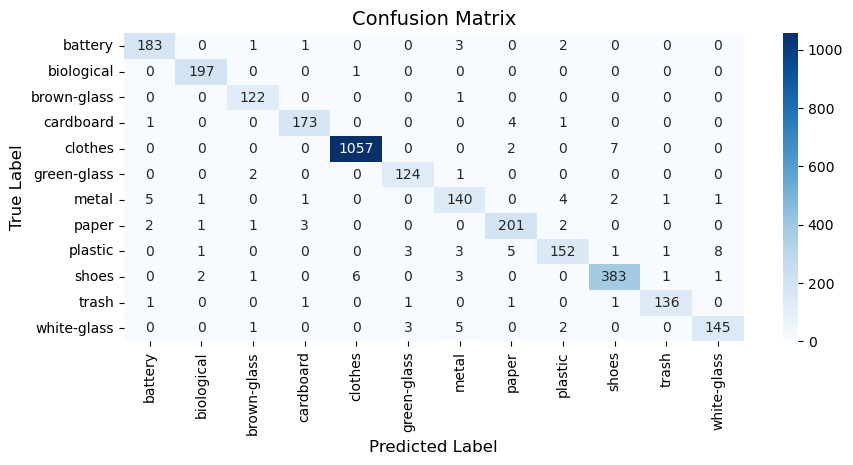

In [166]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [167]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 96.69%
Accuracy for each class:
Class 0: 96.32%
Class 1: 99.49%
Class 2: 99.19%
Class 3: 96.65%
Class 4: 99.16%
Class 5: 97.64%
Class 6: 90.32%
Class 7: 95.71%
Class 8: 87.36%
Class 9: 96.47%
Class 10: 96.45%
Class 11: 92.95%


## RN101

### Data Generation

In [168]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [169]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


In [170]:
from tensorflow.keras.applications.resnet import ResNet101

RN101 = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

171446536/171446536 [==============================] - 6s 0us/step


In [171]:
# Fine tuning

MainInput=Input(shape=(image_size, image_size, 3))
resnet = RN101(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(resnet)

**RN101_cacnn**

In [172]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [173]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn101_ca = Model(inputs=MainInput, outputs=conv)

12


In [174]:
from tensorflow.keras import models
model_rn101_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn101/RN101_CA.hdf5")


In [175]:
predictions_rn101_ca = model_rn101_ca.predict(test_batches)

195/195 [==============================] - 17s 74ms/step


In [176]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_ca

In [177]:
classnames =['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.95      0.95      0.95       190
  biological       0.97      0.98      0.98       198
 brown-glass       0.98      0.98      0.98       123
   cardboard       0.97      0.94      0.95       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.95      0.98      0.97       127
       metal       0.85      0.92      0.88       155
       paper       0.94      0.98      0.96       210
     plastic       0.95      0.92      0.93       174
       shoes       0.96      0.97      0.97       397
       trash       0.99      0.96      0.97       141
 white-glass       0.95      0.88      0.92       156

    accuracy                           0.97      3116
   macro avg       0.95      0.95      0.95      3116
weighted avg       0.97      0.97      0.97      3116



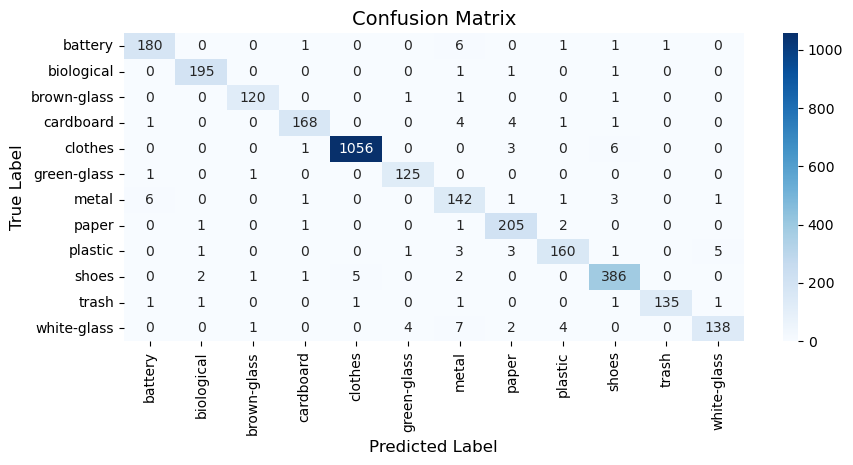

In [178]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [179]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9659820282413351


In [180]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9659820282413351
Top-2 Accuracy: 0.9871630295250321
Top-3 Accuracy: 0.9948652118100129


In [181]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9665893387578307
Weighted Recall (sensitivity): 0.9659820282413351
Weighted F1-Score: 0.9660678164731736
Weighted Specificity: 0.996714339186856
weighted Roc score: 0.9987983485876355


**RN101_seacnn**

In [182]:
### Squeeze and Excitation Attention

def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [183]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn101_sea = Model(inputs=MainInput, outputs=conv)

12


In [184]:
from tensorflow.keras import models
model_rn101_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn101/RN101_SEA.hdf5")


In [185]:
predictions_rn101_sea = model_rn101_sea.predict(test_batches)

195/195 [==============================] - 13s 57ms/step


In [186]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_sea


In [187]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.96      0.97       190
  biological       0.97      0.99      0.98       198
 brown-glass       0.94      0.97      0.96       123
   cardboard       0.98      0.96      0.97       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.95      0.98      0.96       127
       metal       0.88      0.92      0.90       155
       paper       0.95      0.95      0.95       210
     plastic       0.91      0.88      0.89       174
       shoes       0.97      0.97      0.97       397
       trash       0.97      0.99      0.98       141
 white-glass       0.93      0.88      0.90       156

    accuracy                           0.96      3116
   macro avg       0.95      0.95      0.95      3116
weighted avg       0.96      0.96      0.96      3116



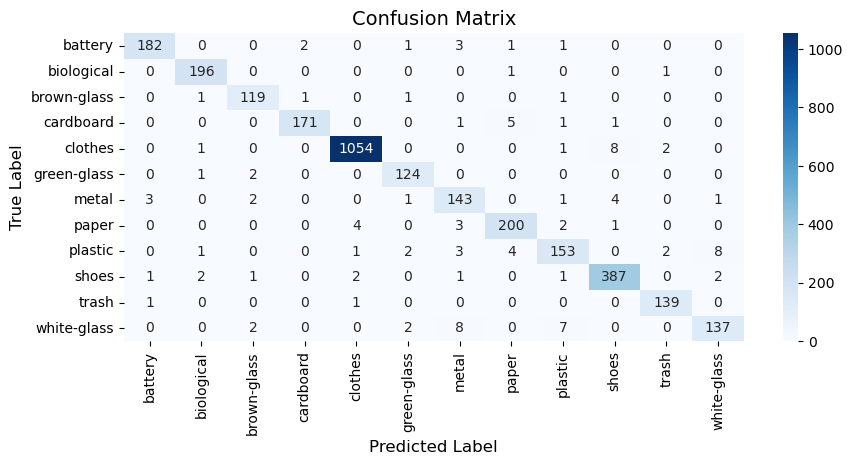

In [188]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [189]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.964377406931964


In [190]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.964377406931964
Top-2 Accuracy: 0.9833119383825417
Top-3 Accuracy: 0.9919768934531451


In [191]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9644702488426674
Weighted Recall (sensitivity): 0.964377406931964
Weighted F1-Score: 0.9643097040126187
Weighted Specificity: 0.9964065366667992
weighted Roc score: 0.9983631007759897


### RN101_sacnn

In [192]:
### Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [193]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn101_sa = Model(inputs=MainInput, outputs=conv)

12


In [194]:
from tensorflow.keras import models
model_rn101_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn101/RN101_SA.hdf5")
predictions = model_rn101_sa.predict(test_batches)

195/195 [==============================] - 13s 59ms/step


In [195]:
predictions_rn101_sa = model_rn101_sa.predict(test_batches)

195/195 [==============================] - 11s 56ms/step


In [196]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_sa


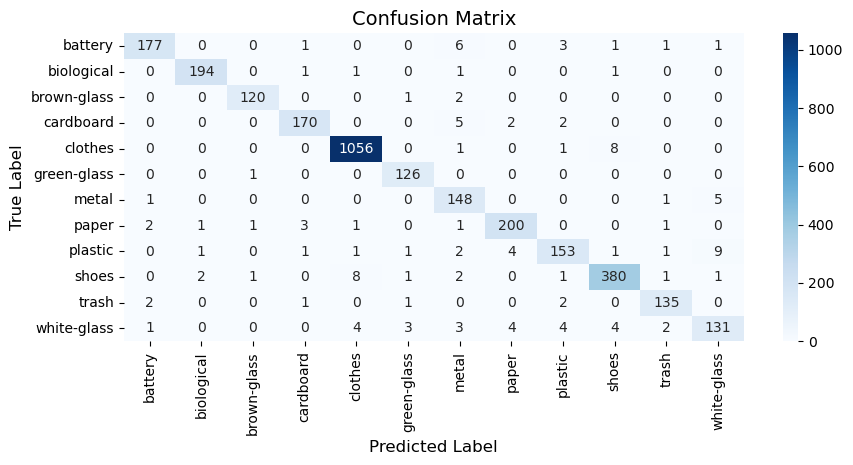

In [197]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [198]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.93      0.95       190
  biological       0.98      0.98      0.98       198
 brown-glass       0.98      0.98      0.98       123
   cardboard       0.96      0.95      0.96       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.95      0.99      0.97       127
       metal       0.87      0.95      0.91       155
       paper       0.95      0.95      0.95       210
     plastic       0.92      0.88      0.90       174
       shoes       0.96      0.96      0.96       397
       trash       0.95      0.96      0.95       141
 white-glass       0.89      0.84      0.86       156

    accuracy                           0.96      3116
   macro avg       0.95      0.95      0.95      3116
weighted avg       0.96      0.96      0.96      3116



In [199]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.959563543003851


In [200]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.959563543003851
Top-2 Accuracy: 0.9797817715019256
Top-3 Accuracy: 0.9862002567394095


In [201]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9597549770774468
Weighted Recall (sensitivity): 0.959563543003851
Weighted F1-Score: 0.9594377971381822
Weighted Specificity: 0.9950677116215353
weighted Roc score: 0.9981366881629792


### SAvg

In [202]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_rn101 = (predictions_rn101_ca + predictions_rn101_sa + predictions_rn101_sea) / 3

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_rn101, axis=1)

In [203]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9749679075738126


In [204]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9752951149117618
Weighted Recall (sensitivity): 0.9749679075738126
Weighted F1-Score: 0.9749463675420941
Weighted Specificity: 0.99739500001722
weighted Roc score: 0.9981366881629792


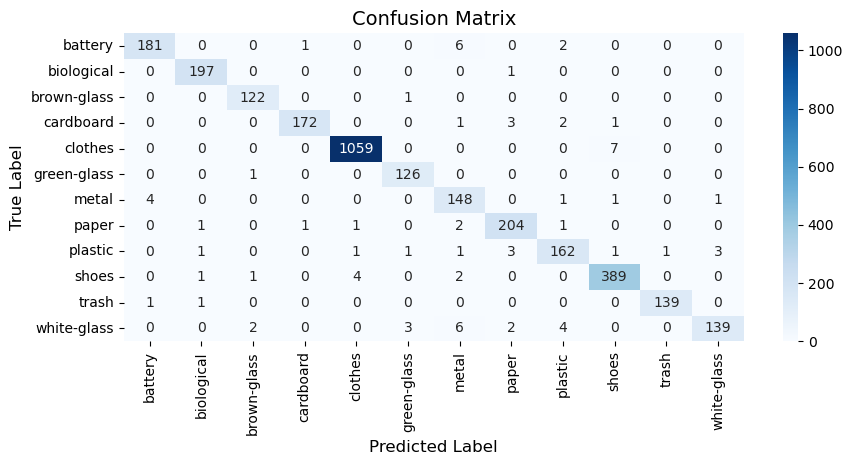

In [205]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [206]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.50%
Accuracy for each class:
Class 0: 95.26%
Class 1: 99.49%
Class 2: 99.19%
Class 3: 96.09%
Class 4: 99.34%
Class 5: 99.21%
Class 6: 95.48%
Class 7: 97.14%
Class 8: 93.10%
Class 9: 97.98%
Class 10: 98.58%
Class 11: 89.10%


**RN152**

**Data Generation**

In [207]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [208]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


### Import model

In [209]:
from tensorflow.keras.applications.resnet import ResNet152

RN152 = ResNet152(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

234698864/234698864 [==============================] - 8s 0us/step


In [210]:
MainInput=Input(shape=(image_size, image_size, 3))
rn152 = RN152(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(rn152)

**RN152-cacnn**

In [211]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [212]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn152_ca = Model(inputs=MainInput, outputs=conv)

12


In [213]:
from tensorflow.keras import models
model_rn152_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn152/RN152_CA.hdf5")


In [214]:
predictions_rn152_ca = model_rn152_ca.predict(test_batches)

195/195 [==============================] - 22s 95ms/step


In [215]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_ca


In [216]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.98      0.95      0.97       190
  biological       0.97      0.98      0.98       198
 brown-glass       0.98      0.95      0.97       123
   cardboard       0.98      0.96      0.97       179
     clothes       0.99      0.99      0.99      1066
 green-glass       0.94      0.98      0.96       127
       metal       0.88      0.95      0.92       155
       paper       0.96      0.96      0.96       210
     plastic       0.90      0.90      0.90       174
       shoes       0.97      0.97      0.97       397
       trash       0.95      0.98      0.97       141
 white-glass       0.92      0.90      0.91       156

    accuracy                           0.97      3116
   macro avg       0.95      0.96      0.95      3116
weighted avg       0.97      0.97      0.97      3116



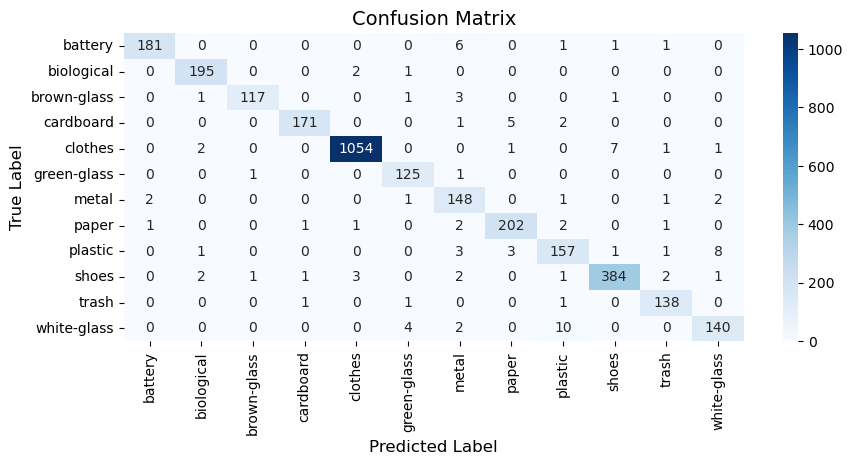

In [217]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [218]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9666238767650834


In [219]:
import numpy as np
from sklearn.metrics import accuracy_score


# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9666238767650834
Top-2 Accuracy: 0.9897304236200257
Top-3 Accuracy: 0.9939024390243902


In [220]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9671564616230917
Weighted Recall (sensitivity): 0.9666238767650834
Weighted F1-Score: 0.9667335418727662
Weighted Specificity: 0.9969470235563673
weighted Roc score: 0.9985974597394697


**RN152-seacnn**

In [221]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [222]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
9
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn152_sea = Model(inputs=MainInput, outputs=conv)

12


In [223]:
from tensorflow.keras import models
model_rn152_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn152/RN152_SEA.hdf5")


In [224]:
predictions_rn152_sea = model_rn152_sea.predict(test_batches)

195/195 [==============================] - 20s 88ms/step


In [225]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_sea


In [226]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.94      0.94      0.94       190
  biological       0.96      0.98      0.97       198
 brown-glass       0.94      0.94      0.94       123
   cardboard       0.96      0.98      0.97       179
     clothes       0.98      0.99      0.98      1066
 green-glass       0.95      0.98      0.97       127
       metal       0.90      0.86      0.88       155
       paper       0.93      0.97      0.95       210
     plastic       0.93      0.85      0.89       174
       shoes       0.96      0.94      0.95       397
       trash       0.94      0.96      0.95       141
 white-glass       0.92      0.89      0.91       156

    accuracy                           0.95      3116
   macro avg       0.94      0.94      0.94      3116
weighted avg       0.95      0.95      0.95      3116



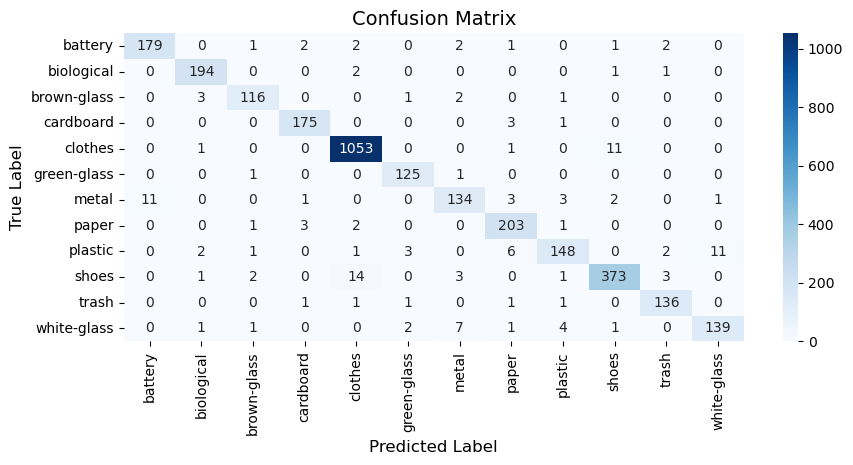

In [227]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [228]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9547496790757382


In [229]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9547496790757382
Top-2 Accuracy: 0.9903722721437741
Top-3 Accuracy: 0.9945442875481386


In [230]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9544823210043872
Weighted Recall (sensitivity): 0.9547496790757382
Weighted F1-Score: 0.954423759137011
Weighted Specificity: 0.9936753059152722
weighted Roc score: 0.9981996186614411


**RN152-sacnn**

In [231]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [232]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn152_sa = Model(inputs=MainInput, outputs=conv)

12


In [233]:
from tensorflow.keras import models
model_rn152_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/rn/rn152/RN152_SA.hdf5")





In [234]:
predictions_rn152_sa = model_rn152_sa.predict(test_batches)

195/195 [==============================] - 20s 87ms/step


In [235]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_sa

In [236]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.92      0.96      0.94       190
  biological       0.96      0.98      0.97       198
 brown-glass       0.94      0.97      0.95       123
   cardboard       0.99      0.95      0.97       179
     clothes       0.98      0.99      0.99      1066
 green-glass       0.90      0.98      0.94       127
       metal       0.93      0.85      0.89       155
       paper       0.94      0.96      0.95       210
     plastic       0.93      0.83      0.88       174
       shoes       0.96      0.95      0.96       397
       trash       0.95      0.96      0.96       141
 white-glass       0.86      0.86      0.86       156

    accuracy                           0.95      3116
   macro avg       0.94      0.94      0.94      3116
weighted avg       0.95      0.95      0.95      3116



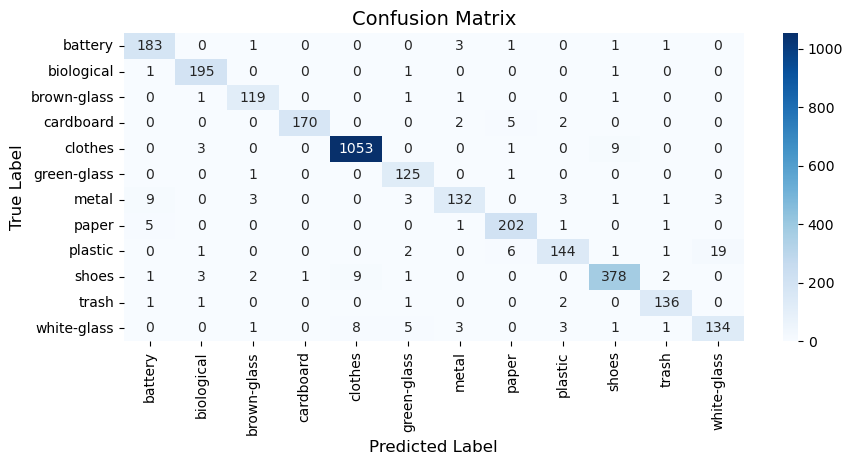

In [237]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [238]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9534659820282413


In [239]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9534659820282413
Top-2 Accuracy: 0.9839537869062901
Top-3 Accuracy: 0.9900513478818999


In [240]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9536785347986194
Weighted Recall (sensitivity): 0.9534659820282413
Weighted F1-Score: 0.9531363752647583
Weighted Specificity: 0.9944139066202505
weighted Roc score: 0.9973361839526967


### WAvg

In [241]:
# weighted average 0.20, .40, .40

# Define the weights for each model's prediction
weights = [0.33, .34, .33]

In [242]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_rn152 = (weights[0] * predictions_rn152_ca) + (weights[1] * predictions_rn152_sea) + (weights[2] * predictions_rn152_sa) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_rn152, axis=1)

In [243]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9746469833119383


In [244]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9747484398605336
Weighted Recall (sensitivity): 0.9746469833119383
Weighted F1-Score: 0.9746093205387599
Weighted Specificity: 0.9972436800544491
weighted Roc score: 0.9973361839526967


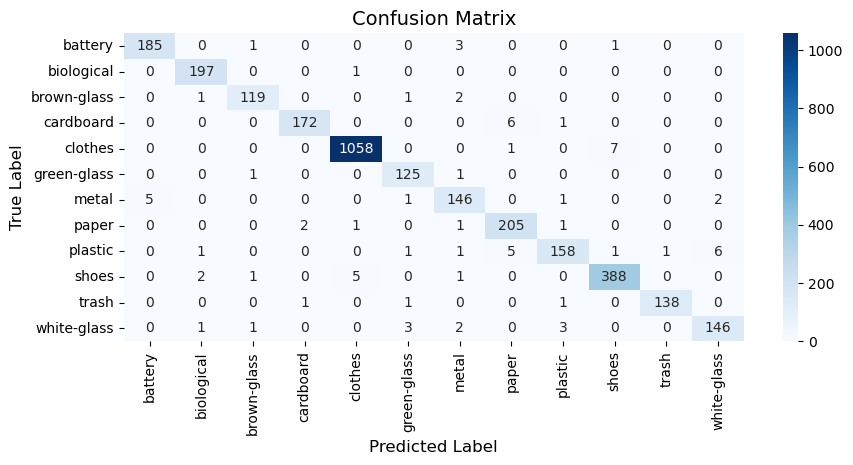

In [245]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [246]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.46%
Accuracy for each class:
Class 0: 97.37%
Class 1: 99.49%
Class 2: 96.75%
Class 3: 96.09%
Class 4: 99.25%
Class 5: 98.43%
Class 6: 94.19%
Class 7: 97.62%
Class 8: 90.80%
Class 9: 97.73%
Class 10: 97.87%
Class 11: 93.59%


### 2nd layer RN

In [247]:
# dn121 = most
# dn201 = 2nd most
# dn169 = 3rd

In [248]:
# Define the weights for each model's prediction
weights = [ .30, .30,0.4]

In [249]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_rn2 = (weights[0] * MV_predictions_rn50) + (weights[1] * WAvg_predictions_rn152) + (weights[2] * SAvg_predictions_rn101) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_rn2, axis=1)

In [250]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9720795892169448


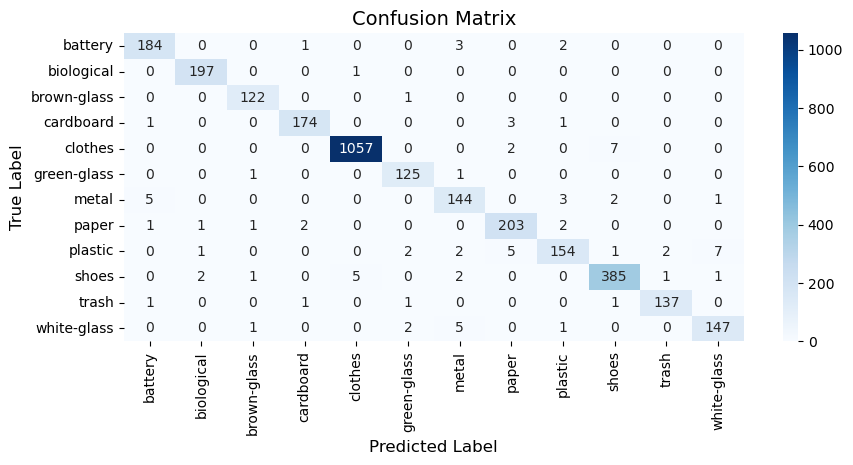

In [251]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [252]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.21%
Accuracy for each class:
Class 0: 96.84%
Class 1: 99.49%
Class 2: 99.19%
Class 3: 97.21%
Class 4: 99.16%
Class 5: 98.43%
Class 6: 92.90%
Class 7: 96.67%
Class 8: 88.51%
Class 9: 96.98%
Class 10: 97.16%
Class 11: 94.23%


# Layer 1 (xc)

Data Generation

In [253]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [254]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 10854 images belonging to 12 classes.

Test Batches: 
Found 3116 images belonging to 12 classes.

Val Batches: 
Found 1545 images belonging to 12 classes.


In [255]:
from tensorflow.keras.applications.xception import Xception

X = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

83683744/83683744 [==============================] - 3s 0us/step


In [256]:
## Fine tuning

MainInput=Input(shape=(image_size, image_size, 3))
xception = X(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(xception)

## X-cacnn

In [257]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [258]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_x_ca = Model(inputs=MainInput, outputs=conv)

12


In [259]:
from tensorflow.keras import models
model_x_ca.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/xc/X_CA.hdf5")

In [260]:
predictions_x_ca = model_x_ca.predict(test_batches)

195/195 [==============================] - 14s 59ms/step


In [261]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_x_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_x_ca

In [262]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       1.00      0.68      0.81       190
  biological       0.96      0.81      0.88       198
 brown-glass       0.97      0.26      0.41       123
   cardboard       0.77      0.93      0.84       179
     clothes       0.84      0.99      0.91      1066
 green-glass       0.99      0.61      0.75       127
       metal       0.79      0.81      0.80       155
       paper       0.93      0.90      0.91       210
     plastic       0.65      0.90      0.76       174
       shoes       0.97      0.87      0.92       397
       trash       0.97      0.83      0.90       141
 white-glass       0.87      0.88      0.87       156

    accuracy                           0.86      3116
   macro avg       0.89      0.79      0.81      3116
weighted avg       0.88      0.86      0.86      3116



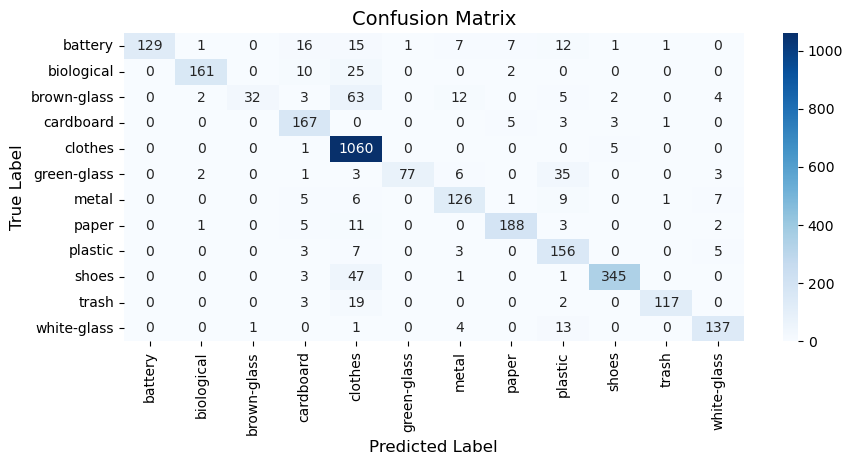

In [263]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [264]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.8648908857509627


In [265]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_x_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_x_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.8648908857509627
Top-2 Accuracy: 0.938382541720154
Top-3 Accuracy: 0.9624518613607189


In [266]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.88272805447268
Weighted Recall (sensitivity): 0.8648908857509627
Weighted F1-Score: 0.8573118215233877
Weighted Specificity: 0.9625951816858435
weighted Roc score: 0.9948215025407524


**X-seacnn**

In [267]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [268]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_x_sea = Model(inputs=MainInput, outputs=conv)

12


In [269]:
from tensorflow.keras import models
model_x_sea.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/xc/X_SEA.hdf5")


In [270]:
predictions_x_sea = model_x_sea.predict(test_batches)

195/195 [==============================] - 10s 45ms/step


In [271]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_x_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_x_sea


In [272]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.97      0.90      0.93       190
  biological       0.94      0.83      0.88       198
 brown-glass       0.92      0.90      0.91       123
   cardboard       0.84      0.94      0.89       179
     clothes       0.99      0.98      0.99      1066
 green-glass       0.94      0.90      0.92       127
       metal       0.86      0.86      0.86       155
       paper       0.66      0.99      0.79       210
     plastic       0.84      0.84      0.84       174
       shoes       0.99      0.90      0.94       397
       trash       0.99      0.87      0.92       141
 white-glass       0.92      0.78      0.84       156

    accuracy                           0.92      3116
   macro avg       0.90      0.89      0.89      3116
weighted avg       0.93      0.92      0.92      3116



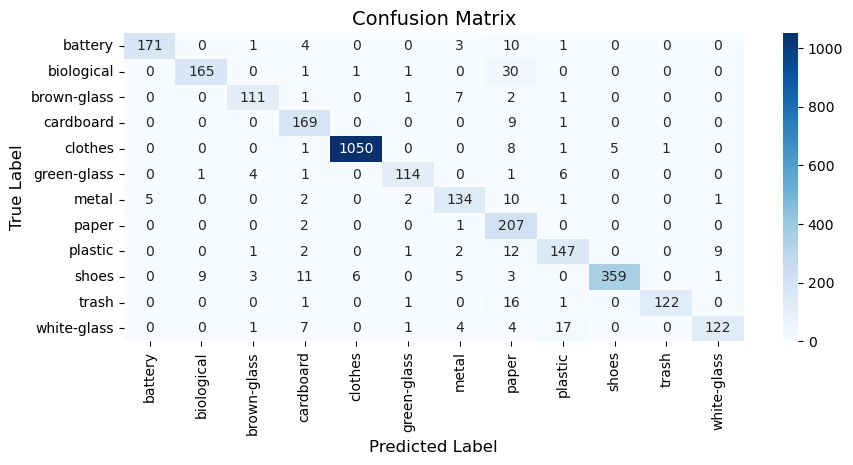

In [273]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [274]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9213735558408216


In [275]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_x_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_x_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9213735558408216
Top-2 Accuracy: 0.9691912708600771
Top-3 Accuracy: 0.9794608472400513


In [276]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9322108516620746
Weighted Recall (sensitivity): 0.9213735558408216
Weighted F1-Score: 0.9234622432225342
Weighted Specificity: 0.993846418254157
weighted Roc score: 0.9955376300384956


**X-sacnn**

In [277]:
### Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [278]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
9
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="softmax")(conv))

model_x_sa = Model(inputs=MainInput, outputs=conv)

12


In [279]:
from tensorflow.keras import models
model_x_sa.load_weights("/kaggle/input/hdf5-garbage/hdf5_garbage/xc/X_SA.hdf5")


In [280]:
predictions_x_sa = model_x_sa.predict(test_batches)

195/195 [==============================] - 12s 54ms/step


In [281]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_x_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_x_sa


In [282]:
classnames = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal','paper','plastic','shoes','trash','white-glass']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     battery       0.99      0.75      0.85       190
  biological       0.99      0.83      0.90       198
 brown-glass       0.95      0.83      0.89       123
   cardboard       0.91      0.94      0.92       179
     clothes       0.91      1.00      0.95      1066
 green-glass       0.98      0.86      0.92       127
       metal       0.67      0.87      0.76       155
       paper       0.80      0.98      0.88       210
     plastic       0.81      0.91      0.86       174
       shoes       0.99      0.80      0.89       397
       trash       0.97      0.85      0.91       141
 white-glass       0.92      0.79      0.85       156

    accuracy                           0.90      3116
   macro avg       0.91      0.87      0.88      3116
weighted avg       0.91      0.90      0.90      3116



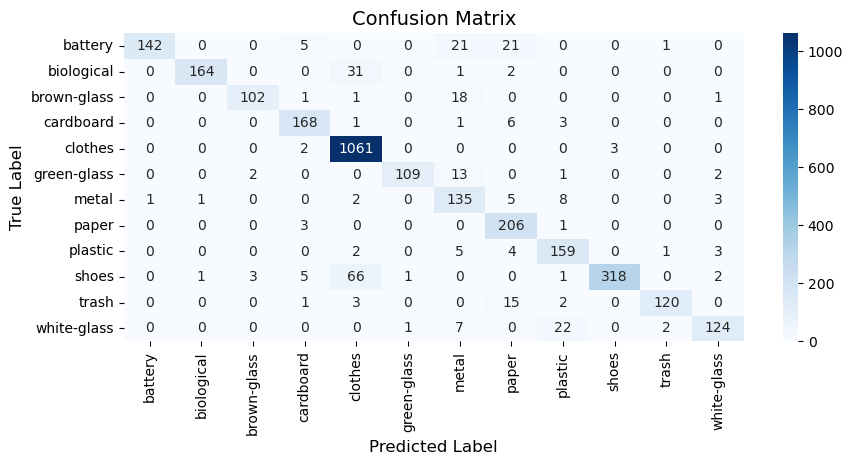

In [283]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [284]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9011553273427471


In [285]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_x_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_x_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9011553273427471
Top-2 Accuracy: 0.9634146341463414
Top-3 Accuracy: 0.977214377406932


In [286]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9122507736183665
Weighted Recall (sensitivity): 0.9011553273427471
Weighted F1-Score: 0.9010293516709489
Weighted Specificity: 0.9783739078512861
weighted Roc score: 0.9958010691667891


**MV**

In [287]:
# Take the majority vote of the predictions for each image
MV_predictions_x = predictions_x_ca + predictions_x_sa + predictions_x_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_x_f = np.argmax(MV_predictions_x, axis=1)

In [288]:
y_pred = MV_predictions_x_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9435173299101413


In [289]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9469318507584176
Weighted Recall (sensitivity): 0.9435173299101413
Weighted F1-Score: 0.9436022666263095
Weighted Specificity: 0.9896996478187335
weighted Roc score: 0.9958010691667891


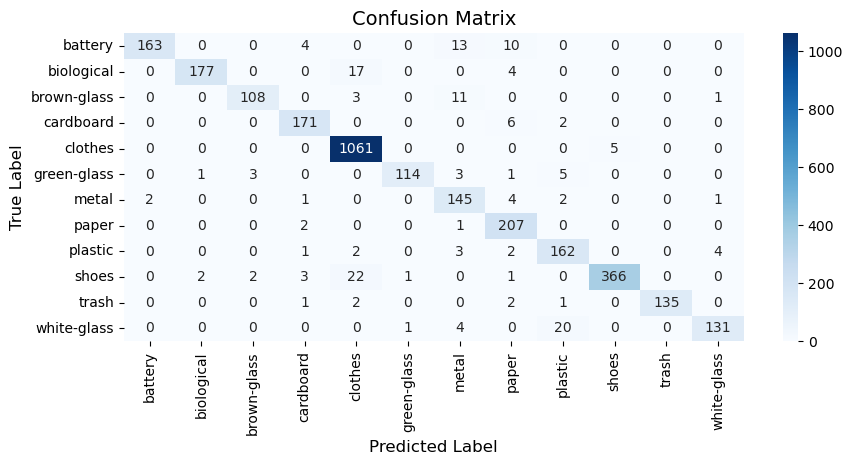

In [290]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [291]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 94.35%
Accuracy for each class:
Class 0: 85.79%
Class 1: 89.39%
Class 2: 87.80%
Class 3: 95.53%
Class 4: 99.53%
Class 5: 89.76%
Class 6: 93.55%
Class 7: 98.57%
Class 8: 93.10%
Class 9: 92.19%
Class 10: 95.74%
Class 11: 83.97%


### SAvg

In [292]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_x = (predictions_x_ca + predictions_x_sa + predictions_x_sea) / 3

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_x, axis=1)

In [293]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9435173299101413


In [294]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9469318507584176
Weighted Recall (sensitivity): 0.9435173299101413
Weighted F1-Score: 0.9436022666263095
Weighted Specificity: 0.9896996478187335
weighted Roc score: 0.9958010691667891


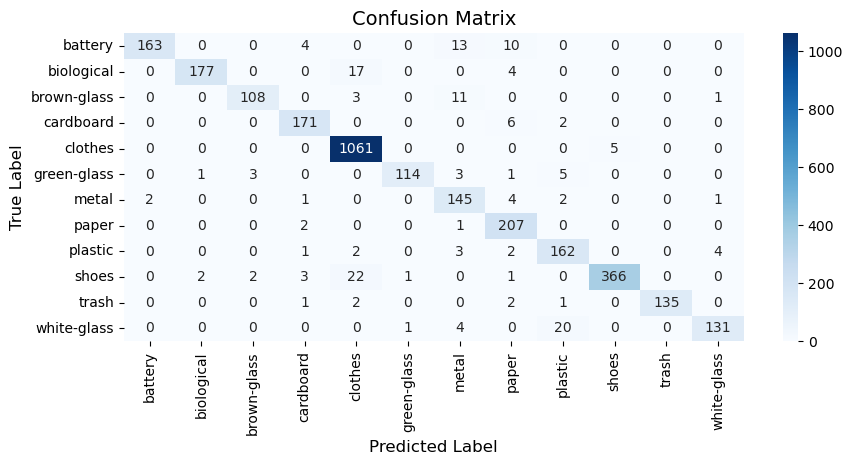

In [295]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [296]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 94.35%
Accuracy for each class:
Class 0: 85.79%
Class 1: 89.39%
Class 2: 87.80%
Class 3: 95.53%
Class 4: 99.53%
Class 5: 89.76%
Class 6: 93.55%
Class 7: 98.57%
Class 8: 93.10%
Class 9: 92.19%
Class 10: 95.74%
Class 11: 83.97%


### WAvg

In [297]:
# weighted average

# Define the weights for each model's prediction
weights = [0.10, .20, .70]


In [298]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_x = (weights[0] * predictions_x_sea) + (weights[1] * predictions_x_ca ) + (weights[2] * predictions_x_sa) / 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_x, axis=1)

In [299]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9345314505776636


In [300]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9393713193813292
Weighted Recall (sensitivity): 0.9345314505776636
Weighted F1-Score: 0.9345997528547536
Weighted Specificity: 0.9864048359496852
weighted Roc score: 0.9958010691667891


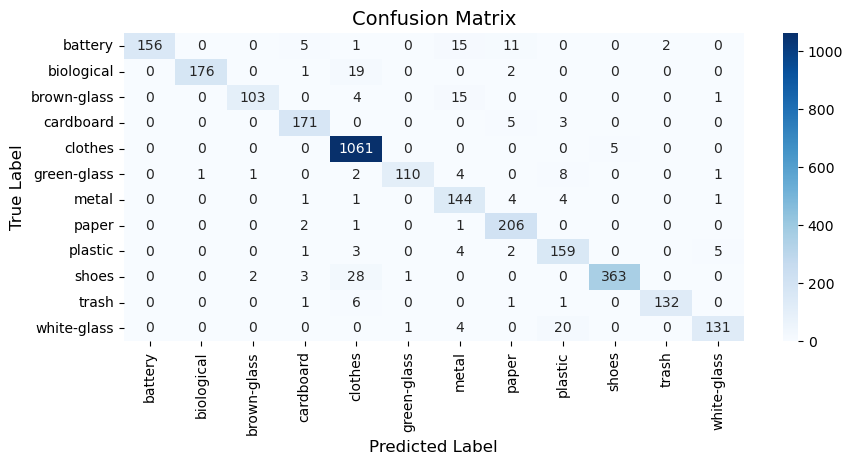

In [301]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [302]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 93.45%
Accuracy for each class:
Class 0: 82.11%
Class 1: 88.89%
Class 2: 83.74%
Class 3: 95.53%
Class 4: 99.53%
Class 5: 86.61%
Class 6: 92.90%
Class 7: 98.10%
Class 8: 91.38%
Class 9: 91.44%
Class 10: 93.62%
Class 11: 83.97%


### 2nd layer x

In [303]:
# Define the weights for each model's prediction
weights = [0.33, .34, .33]

In [304]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_x2 = (weights[0] * MV_predictions_x) + (weights[1] * WAvg_predictions_x) + (weights[2] * SAvg_predictions_x) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_x2, axis=1)




In [305]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9425545571245186


In [306]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9460718674647961
Weighted Recall (sensitivity): 0.9425545571245186
Weighted F1-Score: 0.9425969792876508
Weighted Specificity: 0.9892074275626114
weighted Roc score: 0.9958010691667891


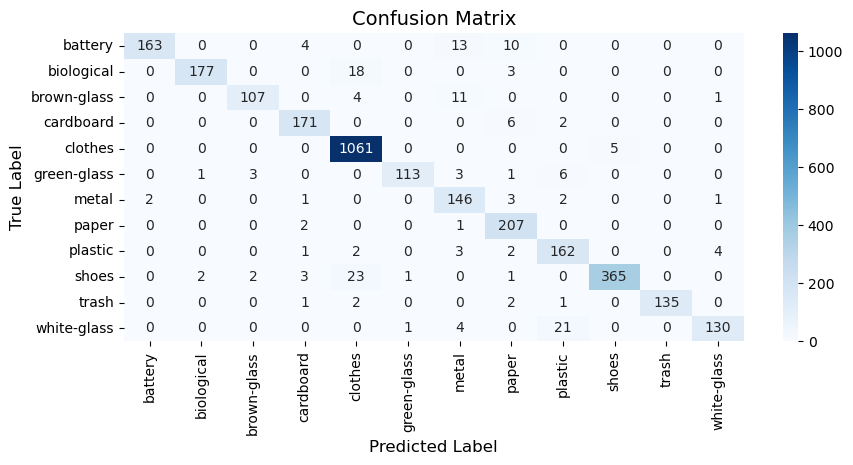

In [307]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [308]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 94.26%
Accuracy for each class:
Class 0: 85.79%
Class 1: 89.39%
Class 2: 86.99%
Class 3: 95.53%
Class 4: 99.53%
Class 5: 88.98%
Class 6: 94.19%
Class 7: 98.57%
Class 8: 93.10%
Class 9: 91.94%
Class 10: 95.74%
Class 11: 83.33%


**3rd Layer**

In [309]:
# Define the weights for each model's prediction
weights = [0.50, 0.50,0.50]

In [310]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_f = (weights[0] * weighted_predictions_dn2) + (weights[1] * weighted_predictions_rn2) + (weights[2] * weighted_predictions_x2) / 2

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_f, axis=1)




In [311]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9784980744544287


In [312]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9785209314380315
Weighted Recall (sensitivity): 0.9784980744544287
Weighted F1-Score: 0.9784602617902712
Weighted Specificity: 0.9977787743108057
weighted Roc score: 0.9958010691667891


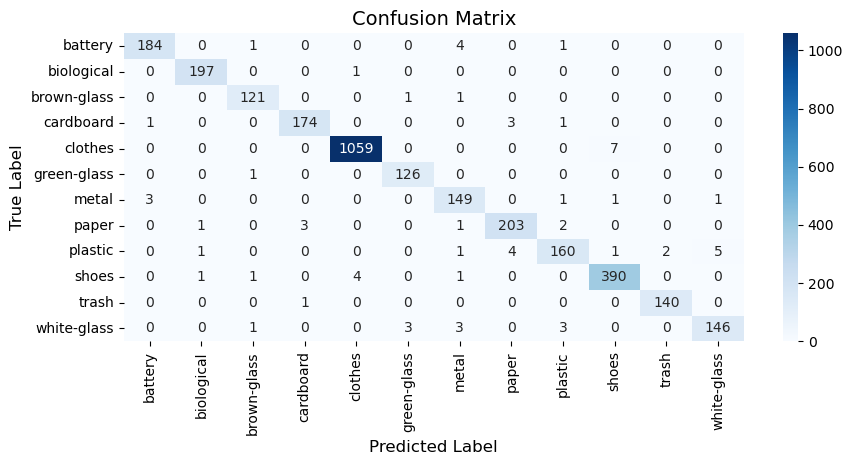

In [313]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [314]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 97.85%
Accuracy for each class:
Class 0: 96.84%
Class 1: 99.49%
Class 2: 98.37%
Class 3: 97.21%
Class 4: 99.34%
Class 5: 99.21%
Class 6: 96.13%
Class 7: 96.67%
Class 8: 91.95%
Class 9: 98.24%
Class 10: 99.29%
Class 11: 93.59%
